## I. Importing libraries and visualizing data and its properties

In [243]:
import numpy as np
import pandas as pd
import re, string, unicodedata
import nltk                                   # Natural language processing tool-kit
# nltk.download('punkt')
# !pip install contractions
nltk.download('stopwords')
# nltk.download('wordnet')
import contractions


from bs4 import BeautifulSoup               
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet  
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [244]:
'''importing data as a dataframe'''
data=pd.read_csv('../Data/Tweets.csv')
data_all = pd.read_csv('../Data/Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [245]:
'''properties of data'''
print('Shape of dataframe is: ',data.shape)
data.describe()

Shape of dataframe is:  (14640, 15)


,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


1. It can be observed from the description table that the count of nefativereason_confidence is less than that of total number of entries. This is because of the presence of NaN values in that column. The NaN values havent been dropped since this data is not used in the training and testing of the model. The more critical data such as the text of the tweet and its sentiment are useful for the best trained model.

## II. Understanding the data

In [246]:
data.drop(data.columns.difference(['airline_sentiment','text']), 1, inplace=True) # Dropping all columns except text and airline sentiment

In [247]:
pd.set_option('display.max_colwidth', None)
print('Shape of the modified dataframe is: ',data.shape)
data.head(10) # Printing first five rows of the data

Shape of the modified dataframe is:  (14640, 2)


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


## III. Pre-processing the data

In [248]:
stopwords=stopwords.words('english')
customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stopwords = list(set(stopwords) - set(customlist))                              
print(stopwords)

# a. HTML tag removal
def html_removal(text):
    parsed=BeautifulSoup(text, "html.parser")
    return parsed.get_text()

'''pre-processing before tokenization'''
def contractions_replace(text):
    return contractions.fix(text)

# b. Tokenization: Performed in the for loop

# c. Numbers removal
def rem_nums(text):
    return re.sub(r'\d+', '', text)

# d. Removal of special characters and punctuations
def rem_punct_spchar(words):
    new_words = []
    for word in words:
        new_word =  re.sub(r'[^\w\s]', '', word)
        if new_word!='':
            new_words.append(new_word)
    return new_words

# e. Conversion to lowercase
def to_lowerc(words):
    new_words=[]
    for word in words:
        new_words.append(word.lower())
    return new_words

def rem_stopwords(words, stopwords):
    new_words=[]
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words
    
# f. Lemmatize/stemming
def lemm(words):
    lemmatizer = WordNetLemmatizer()
    new_words=[]
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

# g. Join the words into a string performed in the for loop

['myself', 's', 'y', 'more', 'again', 'only', 'o', 'from', 'any', 'at', 'i', 'm', 'had', 'her', 'its', 'should', 'during', 'doing', "that'll", 'once', 'here', 'me', 'but', 'being', 'by', 'these', 'between', 'few', 'all', 'yourselves', 'where', 'further', 'did', 'then', 'into', 'was', 'the', 'having', "she's", 'with', 'than', 'after', 'do', 'him', "don't", 'off', 'we', 'that', 'his', 'can', 'aren', 'against', 'why', 'above', 'over', 'or', "it's", 'nor', 't', 'were', 'your', 'yourself', 'very', 'my', 're', 'under', 'just', 'hers', 'themselves', 'because', 'this', 'you', 'herself', 'be', 'couldn', "you'll", 'those', 'while', 'am', 'if', 'them', 'will', 'up', 'ours', 'does', 'before', 'down', 'their', 'have', 'ourselves', 'how', 'himself', 'for', 'own', 'a', 'so', 'd', 'below', 'and', 'on', 'they', 'he', 'each', 'what', 'out', 'other', 'too', 'ain', 'to', 'about', 'until', 'such', 'theirs', 'itself', 'been', 'of', 'most', 'which', 'yours', 'an', 'same', 'who', "you're", 've', 'it', 'both',

In [250]:
words_list=[]; new_words_no_punc=[]; new_words_lowercase=[];new_words_nstopw=[]; new_words_lemm=[]

for i  in range(data.shape[0]):
    text = html_removal(data.text[i]) #a.
    text = contractions_replace(text) 
    text = rem_nums(text) #c.
    words_list=nltk.word_tokenize(text) #b.
    new_words_no_punc = rem_punct_spchar(words_list) #d.
    new_words_lowercase = to_lowerc(new_words_no_punc) #e.
    new_words_nstopw = rem_stopwords(new_words_lowercase, stopwords)
    new_words_lemm = lemm(new_words_nstopw) #f.
    data.text[i] = ' '.join(new_words_lemm) #g.

In [251]:
data.head(5)

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica not today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


In [252]:
'''encoding airline sentiments into integers before vectorization and splitting into training and testing data'''
print('Null values present: True or False? ', data.isnull().values.any())
rstruct={'airline_sentiment':{'neutral':0, 'positive':1, 'negative':2}}
data=data.replace(rstruct)
data.head()

Null values present: True or False?  False


,airline_sentiment,text
0,0,virginamerica dhepburn say
1,1,virginamerica plus add commercials experience tacky
2,0,virginamerica not today must mean need take another trip
3,2,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,2,virginamerica really big bad thing


## IV. Vectorization

In [253]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [254]:
'''count vectorization'''
vectorizer = CountVectorizer(max_features=7320)
data_features = vectorizer.fit_transform(data['text'])
data_features = data_features.toarray()     
data_features.shape

(14640, 7320)

In [255]:
labels=data.airline_sentiment.astype('int')

In [256]:
"splitting into training and testing"
X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)
forest = RandomForestClassifier(n_estimators=15, n_jobs=5)
forest = forest.fit(X_train, y_train)
print(forest)
print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=5,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7200136612021858


[[ 426   67  391]
 [ 109  396  189]
 [ 206   62 2546]]


<AxesSubplot:>

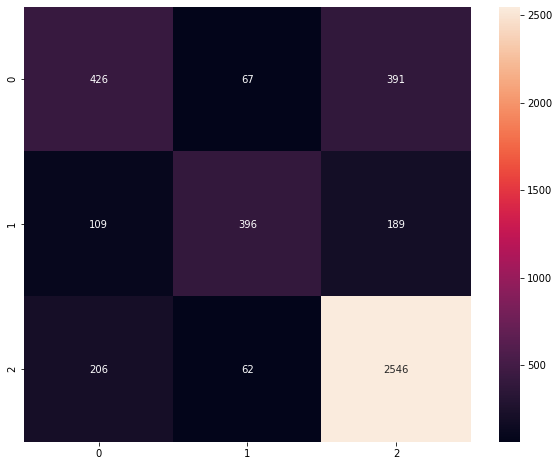

In [257]:
result = forest.predict(X_test)
conf_mat = confusion_matrix(y_test, result)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"], columns = [i for i in "012"])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='g')

In [258]:
'''TFIDF vectorizer'''
vectorizer = TfidfVectorizer(max_features=7320)
data_features = vectorizer.fit_transform(data['text'])
data_features = data_features.toarray()
data_features.shape

(14640, 7320)

In [259]:
"splitting into training and testing"
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_features, labels, test_size=0.3, random_state=42)
forest2 = RandomForestClassifier(n_estimators=15, n_jobs=5)
forest2 = forest.fit(X_train2, y_train2)
print(forest2)
print(np.mean(cross_val_score(forest2, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=5,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7247267759562842


In [260]:
result2 = forest.predict(X_test2)

<AxesSubplot:>

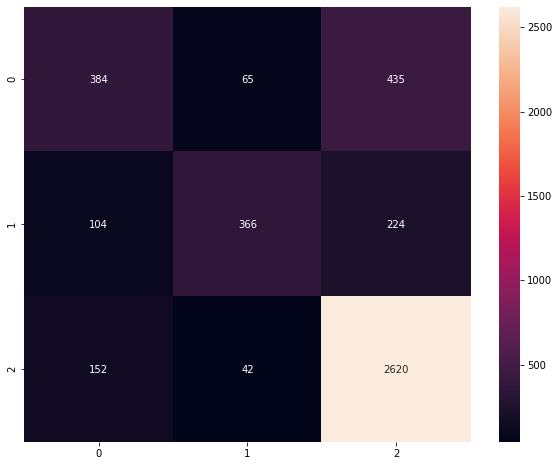

In [261]:
conf_mat2 = confusion_matrix(y_test2, result2)
df_cm2 = pd.DataFrame(conf_mat2, index = [i for i in "012"], columns = [i for i in "012"])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm2, annot=True, fmt='g')

## V. Summarization

1. Dataset used in this assignment was primarily of tweets from customers of VA which had neutral, positive or negative sentiment. These sentiments were converted into integer types corresponding to 0,1,2 respectively.
2. The goal of the assignment was to construct a model which could be used for text classification ie. sentiment analysis in the given text.
3. The  input data is pre-processed so that it is free of html, punctuations, contractions, stop words and numbers. These are done step by step using functions in a for loop. 
4. To keep the sentiment of the text intact, removal of some critical stop words is not carried out.
5. The model is trained and with the help of a randomforest classifier, the test data is used to predict the result. 
6. Number of features used are 7320 which is 50% of the total number of features. This allows room for improvement of accuracy of the model.
7. Two kinds of vectorization: Count vectorization and TFIDF were used to construct the model. TFID shows a marginally higher accuracy than the Count Vectorization.
8. TFIDF is a better tool to vectorize since it balances out the term frequency with the word's inverse frequency unlike count vectorization where the frequency is simply calculated. Hence with count vectorization, there is a possibility of the model placing more importance to trivial words that do not contribute to the sentiment of the text. 